# VideoMAE 2D Training Notebook

This notebook trains a 2D MAE model using an HDF5 dataset:
- Load an HDF5 file from a path
- Split trials into train/val using `split_data`
- Create datasets via `create_dataset('vsd_mae', ...)` and DataLoaders
- Build a 2D MAE (ResNet18 backbone + lightweight decoder)
- Train and log metrics to TensorBoard



In [4]:
# Imports and configuration
import os
import torch
from torch.utils.data import DataLoader

from src.data.dataset_factory import create_dataset
from src.data.split_data import split_data
from src.models.backbone.mae_backbone_2d import MAEResNet18Backbone
from src.models.heads.mae_decoder_2d import MAEDecoder2D
from src.models.systems.mae_system import MAESystem
from src.utils.logger import TBLogger, set_seed

# --- User config ---
HDF5_PATH = r"G:\My Drive\HDF5_DATA_AFTER_PREPROCESSING2\vsd_video_data.hdf5"
LOG_DIR = "logs"
CKPT_DIR = "checkpoints"
SEED = 42

# Data params
CLIP_LENGTH = 1           # 1 -> 2D (single frame); >1 creates clips but MAE2D squeezes T=1
BATCH_SIZE = 8
NUM_WORKERS = 2
SPLIT_RATIO = 0.8

# Masking params for dataset
MASK_RATIO = 0.75
PATCH_SIZE = (1, 16, 16)  # (T, H, W); T=1 for 2D

# Training params
EPOCHS = 5
LR = 1e-4
WEIGHT_DECAY = 0.05

# Setup
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(CKPT_DIR, exist_ok=True)
set_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


Using device: cpu


Visualizing random sample 41905 from dataset
Video tensor shape: torch.Size([1, 1, 100, 100])
Frame range: 86 to 86

📊 Plotting frames sequence...


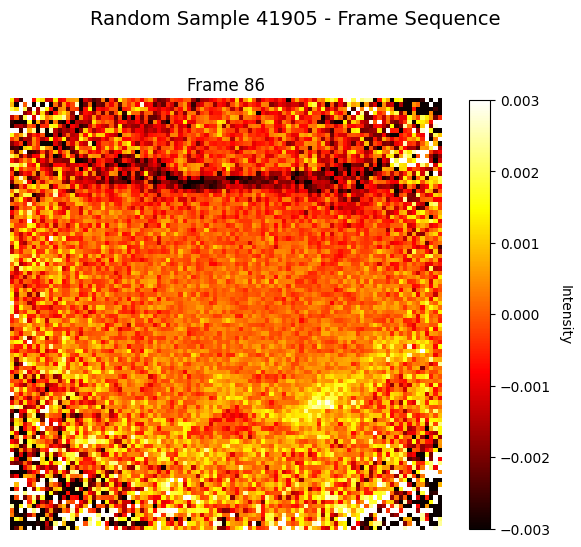


✅ Visualization complete!


In [5]:
# Visualize a random sample before splitting
import random
import matplotlib.pyplot as plt
from src.utils.visualization import plot_frames_sequence, plot_spatial_dynamics

# Create a temporary dataset to sample from (before split)
temp_ds = create_dataset(
    "vsd_video",  # Use base dataset, not masked version for visualization
    hdf5_path=HDF5_PATH,
    clip_length=CLIP_LENGTH,
    normalize=False,
)

# Get a random sample
random_idx = random.randint(0, len(temp_ds) - 1)
sample = temp_ds[random_idx]
video_tensor = sample["video"]  # (C, T, H, W)
start_frame = sample.get("start_frame", 0)
end_frame = sample.get("end_frame", 0)

print(f"Visualizing random sample {random_idx} from dataset")
print(f"Video tensor shape: {video_tensor.shape}")
print(f"Frame range: {start_frame} to {end_frame}")

# Prepare real frame range for visualization
real_frame_range = (int(start_frame), int(end_frame)) if start_frame is not None and end_frame is not None else None

# Plot frames sequence
print("\n📊 Plotting frames sequence...")
fig1 = plot_frames_sequence(
    video_tensor=video_tensor,
    start_frame=0,
    end_frame=None,  # Use all frames
    clipping=(-0.003, 0.003),
    cols=10,
    title=f"Random Sample {random_idx} - Frame Sequence",
    show_plot=True,
    real_frame_range=real_frame_range
)

print("\n✅ Visualization complete!")


In [6]:
# Split data into train/val by trials
train_trials, val_trials, index_entries = split_data(HDF5_PATH, split_ratio=SPLIT_RATIO, random_seed=SEED)
print(f"Train trials: {len(train_trials)} | Val trials: {len(val_trials)}")

Global data split summary:
  Total trials: 212
  Train trials: 169 (79.7%)
  Val trials: 43 (20.3%)
Train trials: 169 | Val trials: 43


In [7]:
# Build datasets and dataloaders
train_ds = create_dataset(
    "vsd_mae",
    hdf5_path=HDF5_PATH,
    clip_length=CLIP_LENGTH,
    frame_start=20,
    frame_end=100,
    trial_indices=train_trials,
    index_entries=index_entries,
    normalize=False,
    mask_ratio=MASK_RATIO,
    patch_size=PATCH_SIZE,
)

val_ds = create_dataset(
    "vsd_mae",
    hdf5_path=HDF5_PATH,
    clip_length=CLIP_LENGTH,
    frame_start=20,
    frame_end=100,
    trial_indices=val_trials,
    index_entries=index_entries,
    normalize=False,
    mask_ratio=MASK_RATIO,
    patch_size=PATCH_SIZE,
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"Train samples: {len(train_ds)} | Val samples: {len(val_ds)}")


Train samples: 13689 | Val samples: 3483


In [8]:
# Build MAE 2D model and optimizer
encoder = MAEResNet18Backbone(pretrained=False, in_channels=1)
decoder = MAEDecoder2D(in_channels=encoder.feature_dim, out_channels=1, hidden_dim=256)

config = {
    "training": {"lr": LR, "weight_decay": WEIGHT_DECAY},
    "loss": {"normalize": True},
}

model = MAESystem(encoder=encoder, decoder=decoder, config=config).to(DEVICE)
optimizer = model.get_optimizer()
logger = TBLogger(log_dir=LOG_DIR)

print(model.__class__.__name__, "built.")


MAESystem built.


In [9]:
# Training loop with TensorBoard logging and simple validation
from tqdm import tqdm

global_step = 0
scaler = torch.cuda.amp.GradScaler()

for epoch in range(EPOCHS):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for batch in pbar:
        # Move batch tensors to device and match MAESystem input keys
        batch = {
            "video_masked": batch.get("video_masked", torch.zeros(1)),
            "video_target": batch.get("video_target", torch.zeros(1)),
            "mask": batch.get("mask", torch.zeros(1)),
        }
        batch = {k: v.to(DEVICE) for k, v in batch.items()}

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            out = model(batch)
            loss = out["loss"]
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Logs
        pbar.set_postfix({"loss": float(loss.item())})
        logger.log_scalar("train/loss", float(loss.item()), global_step)
        for mname, mval in out.get("metrics", {}).items():
            logger.log_scalar(f"train/{mname}", mval, global_step)
        global_step += 1

    # Simple validation (average metrics over one pass)
    model.eval()
    with torch.no_grad():
        val_losses = []
        val_metrics = {}
        for i, batch in enumerate(val_loader):
            batch = {
                "video_masked": batch.get("video_masked", torch.zeros(1)),
                "video_target": batch.get("video_target", torch.zeros(1)),
                "mask": batch.get("mask", torch.zeros(1)),
            }
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            out = model(batch)
            val_losses.append(out["loss"].item())
            for mname, mval in out.get("metrics", {}).items():
                val_metrics.setdefault(mname, []).append(mval)
        if val_losses:
            logger.log_scalar("val/loss", sum(val_losses)/len(val_losses), epoch)
            for mname, arr in val_metrics.items():
                logger.log_scalar(f"val/{mname}", sum(arr)/len(arr), epoch)

    # Save checkpoint each epoch
    ckpt_path = os.path.join(CKPT_DIR, f"mae2d_epoch_{epoch+1}.pt")
    torch.save({
        "encoder": model.encoder.state_dict(),
        "decoder": model.decoder.state_dict(),
        "config": config,
        "epoch": epoch+1,
    }, ckpt_path)
    print(f"Saved checkpoint: {ckpt_path}")

print("Training complete.")


C:\Users\itiel\AppData\Local\Temp\ipykernel_19972\2637288787.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
c:\Users\itiel\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\amp\grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Epoch 1/5:   0%|          | 0/1712 [00:00<?, ?it/s]c:\Users\itiel\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\itiel\AppData\Local\Temp\ipykernel_19972\2637288787.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_availab

KeyboardInterrupt: 

C:\Users\itiel\AppData\Local\Temp\ipykernel_19972\4135983648.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


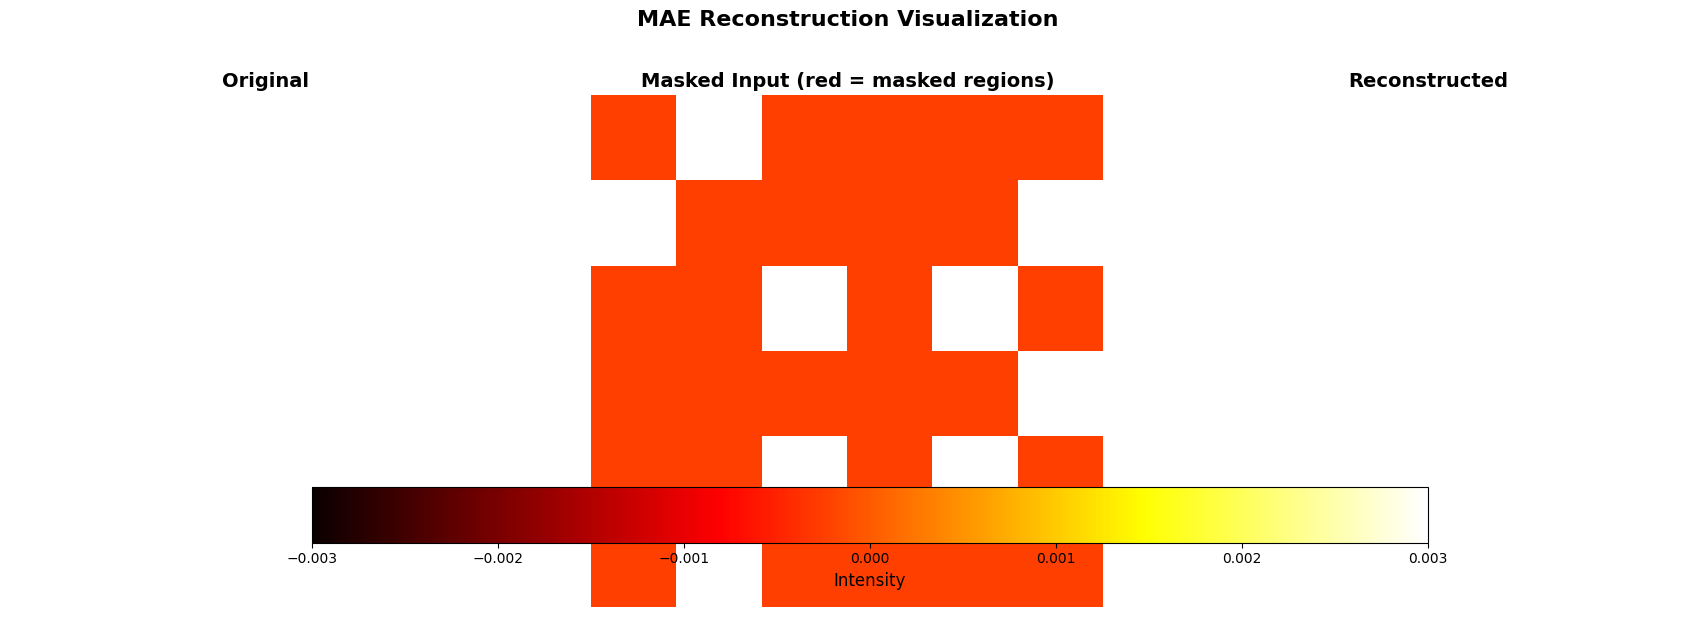

✅ Reconstruction visualization complete!


In [10]:
# Visualize reconstruction: original, masked, and reconstructed
import torch.nn.functional as F
import numpy as np

def get_reconstruction(model, batch):
    """Helper function to get reconstruction from model"""
    model.eval()
    with torch.no_grad():
        video_masked = batch["video_masked"]
        video_target = batch["video_target"]
        mask = batch["mask"]
        
        # Handle 2D case: squeeze temporal dimension if present
        is_2d = False
        if len(video_target.shape) == 5 and video_target.shape[2] == 1:
            is_2d = True
            video_masked = video_masked.squeeze(2)
            video_target = video_target.squeeze(2)
            if len(mask.shape) == 5:
                mask = mask.squeeze(2)
            if len(mask.shape) == 4 and mask.shape[1] == 1:
                H, W = video_target.shape[2], video_target.shape[3]
                mask = F.interpolate(mask, size=(H, W), mode='nearest')
        
        # Forward pass
        features = model.encoder(video_masked)
        if is_2d or len(video_target.shape) == 4:
            target_size = (video_target.shape[2], video_target.shape[3])
            reconstruction = model.decoder(features, target_size=target_size)
        else:
            target_size = (video_target.shape[2], video_target.shape[3], video_target.shape[4])
            reconstruction = model.decoder(features, target_size=target_size)
        
        return reconstruction, mask, video_target, video_masked

# Get a sample from validation set
model.eval()
val_sample = next(iter(val_loader))
val_sample = {k: v.to(DEVICE) for k, v in val_sample.items()}

# Get reconstruction
reconstruction, mask, original, masked = get_reconstruction(model, val_sample)

# Extract first sample from batch
idx = 0
orig_img = original[idx, 0].cpu().numpy()  # (H, W) - single channel
masked_img = masked[idx, 0].cpu().numpy()  # (H, W)
mask_img = mask[idx, 0].cpu().numpy()  # (H, W) - 1=visible, 0=masked
recon_img = reconstruction[idx, 0].cpu().numpy()  # (H, W)

# Create visualization: original, masked with mask overlay, reconstruction
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original image
axes[0].imshow(orig_img, cmap='hot', vmin=-0.003, vmax=0.003)
axes[0].set_title('Original', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Masked image with mask overlay
im = axes[1].imshow(masked_img, cmap='hot', vmin=-0.003, vmax=0.003)
# Overlay mask in red (where mask==0, i.e., masked regions)
mask_overlay = np.zeros((*mask_img.shape, 4))  # RGBA
mask_overlay[:, :, 0] = 1.0  # Red channel
mask_overlay[:, :, 3] = 0.3 * (1 - mask_img)  # Alpha: 0.3 where masked (mask==0)
axes[1].imshow(mask_overlay, interpolation='nearest')
axes[1].set_title('Masked Input (red = masked regions)', fontsize=14, fontweight='bold')
axes[1].axis('off')

# Reconstructed image
axes[2].imshow(recon_img, cmap='hot', vmin=-0.003, vmax=0.003)
axes[2].set_title('Reconstructed', fontsize=14, fontweight='bold')
axes[2].axis('off')

# Add colorbar
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', pad=0.05, shrink=0.8)
cbar.set_label('Intensity', fontsize=12)

plt.suptitle('MAE Reconstruction Visualization', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✅ Reconstruction visualization complete!")
